In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved

# Inference Tutorial

In this tutorial you'll learn:
- [How to load an Omnivore model](#Load-Model)
- [Inference with Images](#Inference-with-Images)
- [Inference with Videos](#Inference-with-Videos)
- [Inference with RGBD images](#Inference-with-RGBD-Images)

### Install modules 

We assume that torch and torchvision have already installed using the instructions in the [README.md](https://github.com/facebookresearch/omnivore/blob/main/README.md#setup-and-installation). We install the other dependencies required for using Omnivore models - `einops`, `pytorchvideo` and `timm`.

For this tutorial, we additionally install `ipywidgets` and `matplotlib`.

In [3]:
import sys


!{sys.executable} -m pip install einops pytorchvideo timm -q

# only needed for the tutorial
# if the video rendering doesn't work, restart the kernel after installation
!{sys.executable} -m pip install ipywidgets matplotlib -q

### Import modules

In [4]:
try:
    from omnivore.transforms import SpatialCrop, TemporalCrop, DepthNorm
except:
    # need to also make the omnivore transform module available
    !git clone https://github.com/facebookresearch/omnivore.git
    sys.path.append("./omnivore")

    from omnivore.transforms import SpatialCrop, TemporalCrop, DepthNorm

import csv
import json
from typing import List

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from pytorchvideo.data.encoded_video import EncodedVideo
from torchvision.transforms._transforms_video import NormalizeVideo

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import Video

<a id=’load-model’></a>
# Load Model

We provide several pretrained Omnivore models via Torch Hub. Available models are described in [model zoo documentation](https://github.com/facebookresearch/omnivore/blob/main/README.md#model-zoo). 

Here we are selecting the `omnivore_swinB` model which was trained on Imagenet 1K, Kinetics 400 and SUN RGBD. 

**NOTE**: to run on GPU in Google Colab, in the menu bar selet: Runtime -> Change runtime type -> Harware Accelerator -> GPU


In [5]:
# Device on which to run the model
# Set to cuda to load on GPU
device = "cpu"

# Pick a pretrained model 
model_name = "omnivore_swinB"
model = torch.hub.load("facebookresearch/omnivore:main", model=model_name)

# Set to eval mode and move to desired device
model = model.to(device)
model = model.eval()

Using cache found in /private/home/miguelmartin/.cache/torch/hub/facebookresearch_omnivore_main
/private/home/miguelmartin/anaconda3/envs/ego_clip/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Inference with Images

First we'll load an image and use the Omnivore model to classify it. 

### Setup

Download the id to label mapping for the Imagenet1K dataset. This will be used to get the category label names from the predicted class ids.

In [6]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json -O imagenet_class_index.json

--2022-06-03 22:02:05--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.38.104
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.38.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2022-06-03 22:02:05 (596 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [7]:
with open("imagenet_class_index.json", "r") as f:
    imagenet_classnames = json.load(f)

# Create an id to label name mapping
imagenet_id_to_classname = {}
for k, v in imagenet_classnames.items():
    imagenet_id_to_classname[k] = v[1] 

### Load and visualize the image

You can download the test image in the cell below or specify a path to your own image. Before passing the image into the model we need to apply some input transforms. 

In [8]:
# Download the example image file
!wget -O library.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/13-11-02-olb-by-RalfR-03.jpg/800px-13-11-02-olb-by-RalfR-03.jpg

--2022-06-03 22:02:08--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/13-11-02-olb-by-RalfR-03.jpg/800px-13-11-02-olb-by-RalfR-03.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180253 (176K) [image/jpeg]
Saving to: ‘library.jpg’

library.jpg         100%[===================>] 176.03K  --.-KB/s    in 0.07s   

2022-06-03 22:02:08 (2.62 MB/s) - ‘library.jpg’ saved [180253/180253]



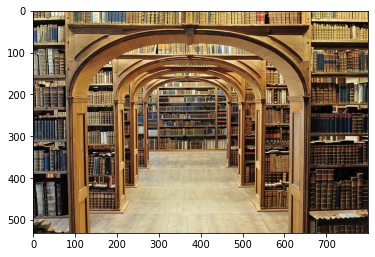

In [9]:
image_path = "library.jpg"
image = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(image)

In [10]:
image_transform = T.Compose(
    [
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = image_transform(image)

# The model expects inputs of shape: B x C x T x H x W
image = image[None, :, None, ...]

### Run the model 

The transformed image can be passed through the model to get class predictions

In [11]:
with torch.no_grad():
    prediction = model(image.to(device), input_type="image")
    pred_classes = prediction.topk(k=5).indices

pred_class_names = [imagenet_id_to_classname[str(i.item())] for i in pred_classes[0]]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: library, bookcase, bookshop, vault, palace


# Inference with Videos

Now we'll see how to use the Omnivore model to classify a video. 


### Setup 

Download the id to label mapping for the Kinetics 400 dataset 
This will be used to get the category label names from the predicted class ids.

In [12]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json -O kinetics_classnames.json

--2022-06-03 22:02:17--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0s      

2022-06-03 22:02:18 (109 MB/s) - ‘kinetics_classnames.json’ saved [10326/10326]



In [13]:
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

### Define the transformations for the input required by the model

Before passing the video into the model we need to apply some input transforms and sample a clip of the correct duration.

In [14]:
num_frames = 160
sampling_rate = 2
frames_per_second = 30

clip_duration = (num_frames * sampling_rate) / frames_per_second

video_transform = ApplyTransformToKey(
    key="video",
    transform=T.Compose(
        [
            UniformTemporalSubsample(num_frames), 
            T.Lambda(lambda x: x / 255.0),  
            ShortSideScale(size=224),
            NormalizeVideo(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            TemporalCrop(frames_per_clip=32, stride=40),
            SpatialCrop(crop_size=224, num_crops=3),
        ]
    ),
)

### Load and visualize an example video
We can test the classification of an example video from the kinetics validation set such as this [archery video](https://www.youtube.com/watch?v=3and4vWkW4s).

In [15]:
# Download the example video file
!wget https://dl.fbaipublicfiles.com/omnivore/example_data/dance.mp4 -O dance.mp4

--2022-06-03 22:02:23--  https://dl.fbaipublicfiles.com/omnivore/example_data/dance.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606429 (4.4M) [video/mp4]
Saving to: ‘dance.mp4’

dance.mp4           100%[===================>]   4.39M  14.5MB/s    in 0.3s    

2022-06-03 22:02:23 (14.5 MB/s) - ‘dance.mp4’ saved [4606429/4606429]



In [ ]:
# Load the example video
video_path = "dance.mp4" 

Video.from_file(video_path, width=500)

In [17]:
# We crop the video to a smaller resolution and duration to save RAM
!ffmpeg -y -ss 0 -i dance.mp4 -filter:v scale=224:-1 -t 1 -v 0 dance_cropped.mp4

video_path = "dance_cropped.mp4" 

In [18]:
# Initialize an EncodedVideo helper class
video = EncodedVideo.from_path(video_path)

# Load the desired clip and specify the start and end duration.
# The start_sec should correspond to where the action occurs in the video
video_data = video.get_clip(start_sec=0, end_sec=2.0)

# Apply a transform to normalize the video input
video_data = video_transform(video_data)

# Move the inputs to the desired device
video_inputs = video_data["video"]

# Take the first clip 
# The model expects inputs of shape: B x C x T x H x W
video_input = video_inputs[0][None, ...]

### Get model predictions

In [19]:
# Pass the input clip through the model 
with torch.no_grad():
    prediction = model(video_input.to(device), input_type="video")

    # Get the predicted classes 
    pred_classes = prediction.topk(k=5).indices

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: jumpstyle dancing, dancing ballet, breakdancing, juggling balls, robot dancing


# Inference with RGBD Images

Now we'll see how to use the Omnivore model to classify an image with a depth map. 


### Setup 

Download the id to label mapping for the SUN RGBD dataset with 19 classes. 
This will be used to get the category label names from the predicted class ids.

In [20]:
!wget https://dl.fbaipublicfiles.com/omnivore/sunrgbd_classnames.json -O sunrgbd_classnames.json 

--2022-06-03 22:02:45--  https://dl.fbaipublicfiles.com/omnivore/sunrgbd_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373 [application/json]
Saving to: ‘sunrgbd_classnames.json’

sunrgbd_classnames. 100%[===================>]     373  --.-KB/s    in 0s      

2022-06-03 22:02:45 (91.8 MB/s) - ‘sunrgbd_classnames.json’ saved [373/373]



In [21]:
with open("sunrgbd_classnames.json", "r") as f:
    sunrgbd_id_to_classname = json.load(f)

### Define the transformations for the input required by the model

Before passing the RGBD image into the model we need to apply some input transforms. 

Here, the depth statistics (max, mean, std) are based on the SUN RGBD dataset)

In [22]:
rgbd_transform = T.Compose(
    [
        DepthNorm(max_depth=75.0, clamp_max_before_scale=True),
        T.Resize(224),
        T.CenterCrop(224),
        T.Normalize(
            mean=[0.485, 0.456, 0.406, 0.0418], 
            std=[0.229, 0.224, 0.225, 0.0295]
        ),
    ]
)

### Download an example image and depth

We can test the classification of an example RGBD image from the SUN RGBD validation set. 

In [23]:
# Download the example image and disparity file
!wget -O store.png https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Interior_of_the_IKEA_B%C4%83neasa_33.jpg/791px-Interior_of_the_IKEA_B%C4%83neasa_33.jpg
!wget -O store_disparity.pt https://dl.fbaipublicfiles.com/omnivore/example_data/store_disparity.pt 

--2022-06-03 22:02:48--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Interior_of_the_IKEA_B%C4%83neasa_33.jpg/791px-Interior_of_the_IKEA_B%C4%83neasa_33.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165941 (162K) [image/jpeg]
Saving to: ‘store.png’

store.png           100%[===================>] 162.05K  --.-KB/s    in 0.07s   

2022-06-03 22:02:48 (2.29 MB/s) - ‘store.png’ saved [165941/165941]

--2022-06-03 22:02:48--  https://dl.fbaipublicfiles.com/omnivore/example_data/store_disparity.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899115 (1.8M) [binary/octet-stream]
S

### Load and visualize the image and depth map

(Notice the price tags on the furniture items in the image of the bedroom)

Text(0.5, 1.0, 'Depth')

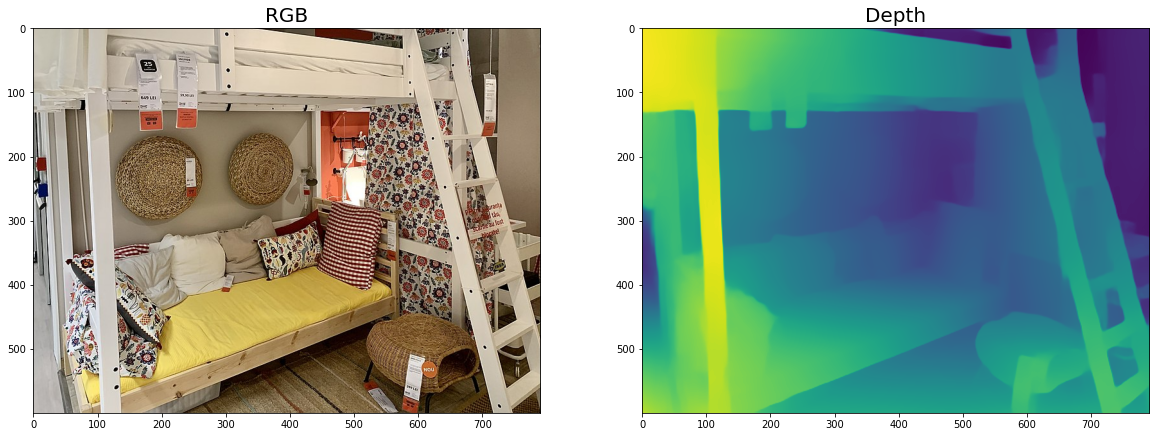

In [24]:
image_path = "./store.png"
depth_path = "./store_disparity.pt"
image = Image.open(image_path).convert("RGB")
depth = torch.load(depth_path)[None, ...]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("RGB", fontsize=20)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(depth.numpy().squeeze())
plt.title("Depth", fontsize=20)

In [25]:
# Convert to tensor and transform
image = T.ToTensor()(image)
rgbd = torch.cat([image, depth], dim=0)
rgbd = rgbd_transform(rgbd)

# The model expects inputs of shape: B x C x T x H x W
rgbd_input = rgbd[None, :, None, ...]

### Get model predictions

In [26]:
with torch.no_grad():
    prediction = model(rgbd_input.to(device), input_type="rgbd")
    pred_classes = prediction.topk(k=5).indices

pred_class_names = [sunrgbd_id_to_classname[str(i.item())] for i in pred_classes[0]]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: furniture_store, bedroom, bathroom, rest_space, office


# Inference with Egocentric videos

We can also use the Omnivore model to classify an egocentric video from the EPIC Kitchens dataset. 

### Setup 

First load the omnivore model trained on the epic kitchens dataset

In [ ]:
model_name = "omnivore_swinB_epic"
model = torch.hub.load("facebookresearch/omnivore:main", model=model_name)

# Set to eval mode and move to desired device
model = model.to(device)
model = model.eval()

Download the id to label mapping for the EPIC Kitchens 100 dataset. 
This will be used to get the action class names from the predicted class ids.

In [28]:
!wget https://dl.fbaipublicfiles.com/omnivore/epic_action_classes.csv

--2022-06-03 22:03:37--  https://dl.fbaipublicfiles.com/omnivore/epic_action_classes.csv
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47622 (47K) [text/csv]
Saving to: ‘epic_action_classes.csv’

epic_action_classes 100%[===================>]  46.51K  --.-KB/s    in 0.03s   

2022-06-03 22:03:38 (1.54 MB/s) - ‘epic_action_classes.csv’ saved [47622/47622]



In [29]:
with open('epic_action_classes.csv', mode='r') as inp:
    reader = csv.reader(inp)
    epic_id_to_action = {idx: " ".join(rows) for idx, rows in enumerate(reader)}

### Define the transformations for the input required by the model

Before passing the video into the model we need to apply some input transforms and sample a clip of the correct duration.

In [30]:
num_frames = 32
sampling_rate = 2
frames_per_second = 30

clip_duration = (num_frames * sampling_rate) / frames_per_second

video_transform = ApplyTransformToKey(
    key="video",
    transform=T.Compose(
        [
            UniformTemporalSubsample(num_frames), 
            T.Lambda(lambda x: x / 255.0),  
            ShortSideScale(size=224),
            NormalizeVideo(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            TemporalCrop(frames_per_clip=32, stride=40),
            SpatialCrop(crop_size=224, num_crops=3),
        ]
    ),
)

### Load and visualize an example video
We can test the classification of an example video from the epic kitchens dataset (see [trailer](https://www.youtube.com/watch?v=8IzkrWAfAGg&t=5s) here). 

In [31]:
# Download the example video file
!wget https://dl.fbaipublicfiles.com/omnivore/example_data/epic.mp4 -O epic.mp4

--2022-06-03 22:03:40--  https://dl.fbaipublicfiles.com/omnivore/example_data/epic.mp4
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1054446 (1.0M) [video/mp4]
Saving to: ‘epic.mp4’

epic.mp4            100%[===================>]   1.00M  4.80MB/s    in 0.2s    

2022-06-03 22:03:40 (4.80 MB/s) - ‘epic.mp4’ saved [1054446/1054446]



In [ ]:
# Load the example video
video_path = "epic.mp4" 

Video.from_file(video_path, width=500)

In [33]:
# We crop the video to a smaller resolution and duration to save RAM
!ffmpeg -y -ss 0 -i epic.mp4 -filter:v scale=224:-1 -t 1 -v 0 epic_cropped.mp4

video_path = "epic_cropped.mp4" 

In [34]:
# Initialize an EncodedVideo helper class
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=0.0, end_sec=2.0)

# Apply a transform to normalize the video input
video_data = video_transform(video_data)

# Move the inputs to the desired device
video_inputs = video_data["video"]

# Take the first clip 
# The model expects inputs of shape: B x C x T x H x W
video_input = video_inputs[0][None, ...]

### Get model predictions

In [35]:
# Pass the input clip through the model 
with torch.no_grad():
    prediction = model(video_input.to(device), input_type="video")

    # Get the predicted classes 
    pred_classes = prediction.topk(k=5).indices

# Map the predicted classes to the label names
pred_class_names = [epic_id_to_action[int(i)] for i in pred_classes[0]]
print("Top 5 predicted actions: %s" % ", ".join(pred_class_names))

Top 5 predicted actions: take peach, take mixture, take hand, take book, put liquid:washing
